# Audio Data Collection and Processing
This notebook loads, augments, and extracts features from group member recorded audio.

In [1]:
# Install required libraries
!pip install librosa numpy pandas matplotlib soundfile

  Using cached scipy-1.16.0-cp311-cp311-macosx_14_0_arm64.whl.metadata (61 kB)
  Using cached joblib-1.5.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
  Using cached cffi-1.17.1-cp311-cp311-macosx_11_0_arm64.whl.metadata (1.5 kB)
  Using cached pycparser-2.22-py3-none-any.whl.metadata (943 bytes)
  Using cached requests-2.32.4-py3-none-any.whl.metadata (4.9 kB)
  Using cached charset_normalizer-3.4.2-cp311-cp311-macosx_10_9_universal2.whl.metadata (35 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached urllib3-2.5.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 368.8 kB/s eta 0:00:000:00:01
Using cached cffi-1.17.1-cp311-cp311-macosx_11_0_arm64.whl (178 kB)
Using cached joblib-1.5.1-py3-none-any.whl (307 kB)
Using cached lazy_loader-0.4-py3-none-any.whl (12 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Import necessary libraries
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import soundfile as sf
import librosa.display

In [3]:
# Define members and audio samples
members = ['david', 'nicolle', 'chance', 'annabelle', 'tamanda']
samples = ['approve', 'confirm']
base_path = '../audio'

def load_audio(member, sample):
    for ext in ['wav', 'mp3']:
        path = os.path.join(base_path, member, f'{sample}.{ext}')
        if os.path.exists(path):
            y, sr = librosa.load(path, sr=None)
            return y, sr
    raise FileNotFoundError(f'No audio found for {member} - {sample}')


/var/folders/d9/gxzpvsdd0c52kmn6py36t0qm0000gn/T/ipykernel_6679/524880253.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=None)
/Users/davidniyonshutii/Documents/machine learning pipeline/ML_Pipeline_assignment2/.venv/lib/python3.11/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


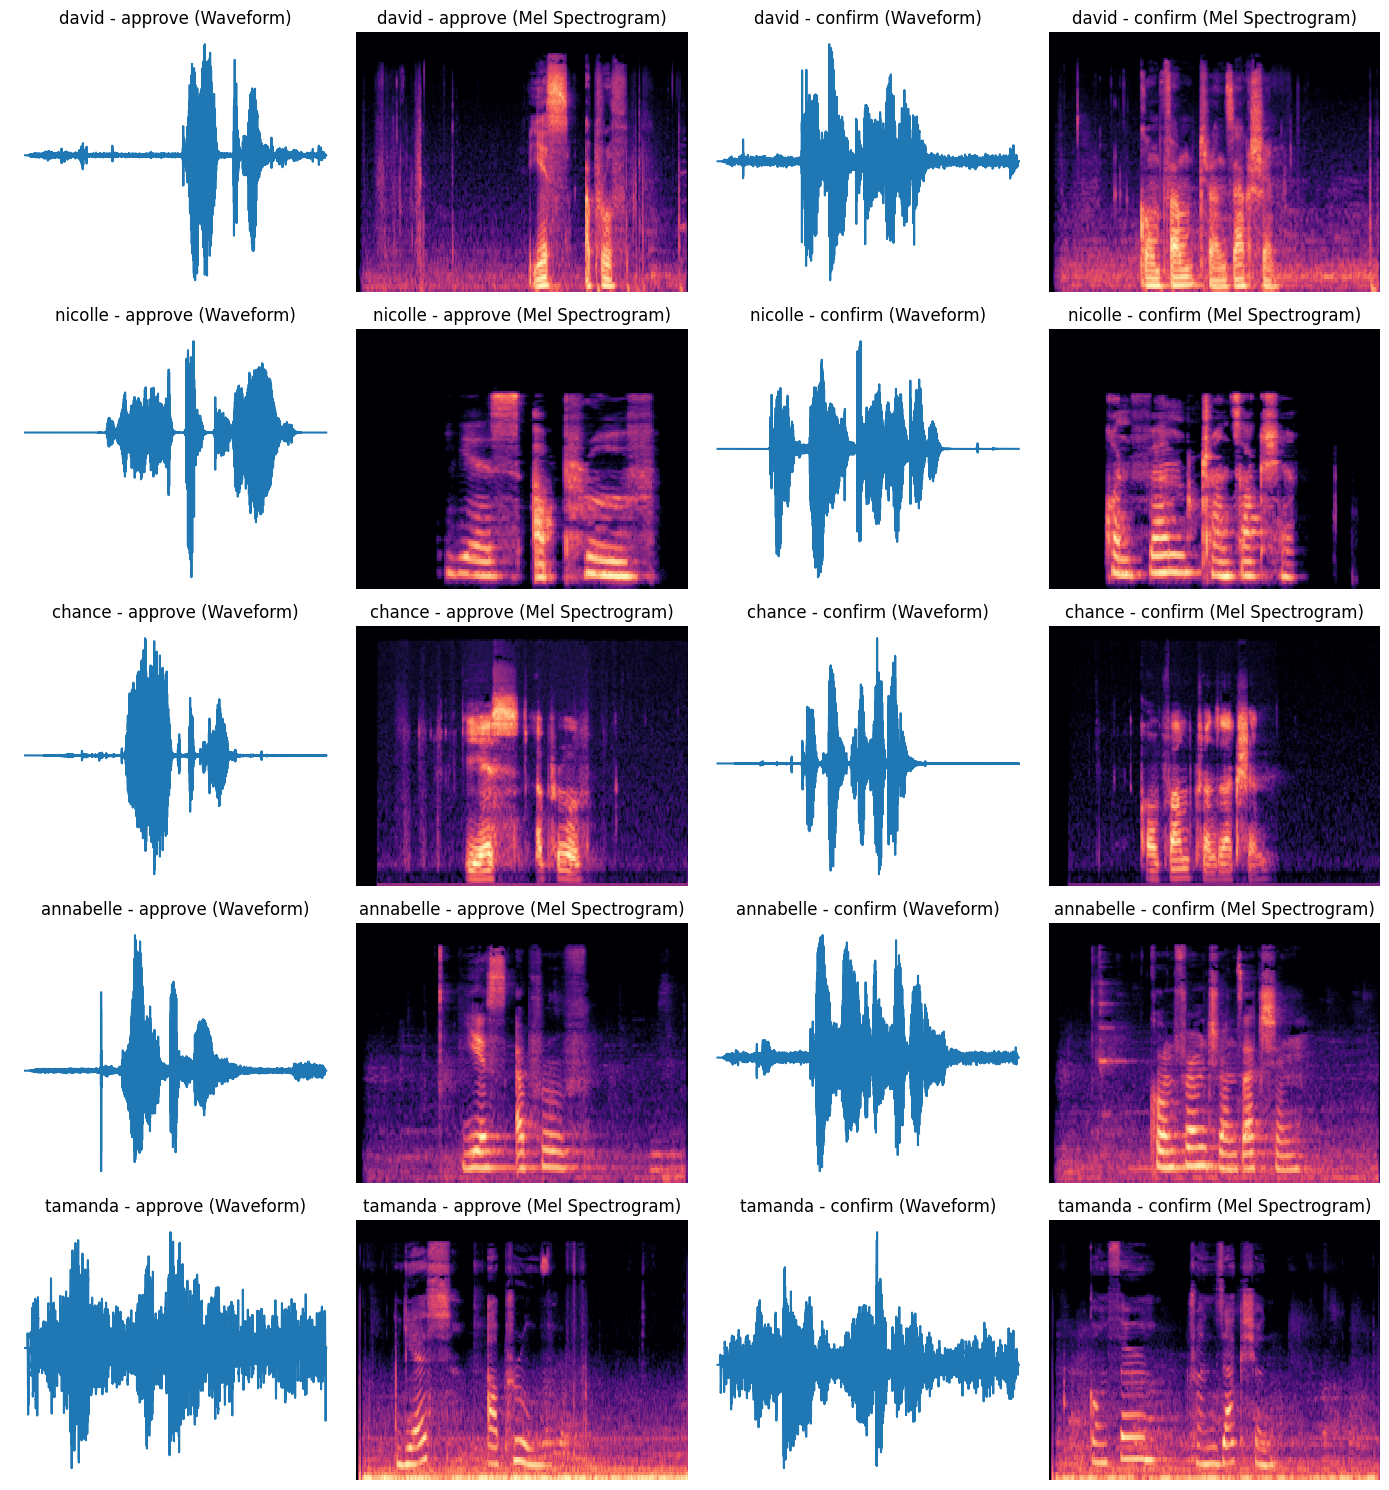

In [14]:
# Display waveforms and spectrograms
fig, axs = plt.subplots(len(members), len(samples)*2, figsize=(14, 15))
for i, member in enumerate(members):
    for j, sample in enumerate(samples):
        y, sr = load_audio(member, sample)
        # Waveform
        axs[i, j*2].plot(y)
        axs[i, j*2].set_title(f'{member} - {sample} (Waveform)')
        axs[i, j*2].axis('off')
        # Spectrogram
        S = librosa.feature.melspectrogram(y=y, sr=sr)
        S_dB = librosa.power_to_db(S, ref=np.max)
        librosa.display.specshow(S_dB, sr=sr, ax=axs[i, j*2+1], x_axis='time', y_axis='mel')
        axs[i, j*2+1].set_title(f'{member} - {sample} (Mel Spectrogram)')
        axs[i, j*2+1].axis('off')
plt.tight_layout()
plt.show()

In [20]:
# Augmentation functions and save augmented audio into folder ../augmented_audios
def augment_audio(y, sr):
    # Pitch shift
    y_pitch = librosa.effects.pitch_shift(y=y, sr=sr, n_steps=2)
    # Time stretch
    y_stretch = librosa.effects.time_stretch(y, rate=1.2)
    # Add background noise
    noise = np.random.normal(0, 0.005, y.shape)
    y_noise = y + noise
    return [y, y_pitch, y_stretch, y_noise]

In [21]:
# Feature extraction (MFCCs, spectral roll-off, energy)
def extract_features(y, sr):
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).mean(axis=1)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr).mean()
    energy = np.mean(y**2)
    features = {'energy': energy, 'rolloff': rolloff}
    for i, mfcc in enumerate(mfccs):
        features[f'mfcc_{i}'] = mfcc
    return features

In [23]:
# Process all audio, augment, extract features, and save
rows = []
aug_types = ['original', 'pitch', 'stretch', 'noise']
for member in members:
    for sample in samples:
        y, sr = load_audio(member, sample)
        aug_audios = augment_audio(y, sr)
        for aug_type, aug_y in zip(aug_types, aug_audios):
            feats = extract_features(aug_y, sr)
            row = {'member': member, 'sample': sample, 'augmentation': aug_type}
            row.update(feats)
            rows.append(row)
            # Save augmented audio
            aug_path = os.path.join('../augmented_audios', f'{member}_{sample}_{aug_type}.wav')
            os.makedirs(os.path.dirname(aug_path), exist_ok=True)
            sf.write(aug_path, aug_y, sr)
df = pd.DataFrame(rows)
df.to_csv('../audio_features.csv', index=False)
print("Data saved to ../audio_features.csv ✅")
df.head()

/var/folders/d9/gxzpvsdd0c52kmn6py36t0qm0000gn/T/ipykernel_6679/524880253.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=None)
/Users/davidniyonshutii/Documents/machine learning pipeline/ML_Pipeline_assignment2/.venv/lib/python3.11/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Data saved to ../audio_features.csv ✅


,member,sample,augmentation,energy,rolloff,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12
0,david,approve,original,0.001125,5532.897534,-470.388733,115.434631,10.793375,36.576359,5.174695,19.042986,2.409958,6.798976,7.123512,0.306631,5.249000,-3.113587,1.810558
1,david,approve,pitch,0.000563,6390.997024,-496.560272,107.548767,14.688319,32.677586,4.130080,18.449661,-0.713317,9.971756,2.471186,2.218746,2.638993,-2.400248,4.762332
2,david,approve,stretch,0.000520,5738.483481,-502.090332,112.294426,10.916822,36.193268,4.142584,18.785419,2.008073,6.771557,6.970181,0.301082,6.034530,-3.361459,1.591592
3,david,approve,noise,0.001149,18446.853741,-315.086473,26.225565,15.723828,18.246023,7.690150,10.177798,6.418136,4.844470,5.583466,2.479509,2.543774,0.516795,1.073807
4,david,confirm,original,0.001037,3318.497475,-451.448822,155.922226,17.962776,33.061432,4.993365,15.411249,0.774826,5.132216,5.629819,-5.929314,1.279346,-5.014614,2.280145
